In [ ]:
pip install tensorflow==1.14.0

     |████████████████████████████████| 109.3 MB 39 kB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 3.1 MB 38.1 MB/s 
     |████████████████████████████████| 488 kB 51.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you

In [ ]:
pip install scikit-plot

In [ ]:
!pip install keras==2.2.4

     |████████████████████████████████| 312 kB 5.2 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0


In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.


In [ ]:
import os
import random
import itertools
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework import graph_io

import cv2

from sklearn.metrics import confusion_matrix, accuracy_score
from glob import glob
import pickle


## FLOW GENERATORS ###
from google.colab import drive
drive.mount('/content/drive')

# define the constants
BATCH_SIZE = 64
LEARNING_RATE = 1e-4 #0.0002
EPOCHS = 64

num_classes = 3
CLASS_NAMES = ["Dry","Wet","Dirty"]

Mounted at /content/drive


[INFO] loading data files...
3349
3349
838
838
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/64
52/52 [==============================] - 59s 1s/step - loss: 6.0205 - acc: 0.5339 - val_loss: 1.8652 - val_acc: 0.7248
Epoch 2/64
52/52 [==============================] - 53s 1s/step - loss: 1.9047 - acc: 0.6676 - val_loss: 0.9779 - val_acc: 0.7680
Epoch 3/64
52/52 [==============================] - 52s 996ms/step - loss: 1.2003 - acc: 0.6755 - val_loss: 0.7449 - val_acc: 0.7740
Epoch 4/64
52/52 [==============================] - 52s 991ms/step - loss: 0.8419 - acc: 0.7002 - val_loss: 0.6273 - val_acc: 0.7764
Epoch 5/64
52/52 [==============================] - 51s 985ms/step - loss: 0.7604 - acc: 0.7160 - val_loss: 0.5777 - val_acc: 0.7837
Epoch 6/64
52/52 [==============================] - 51s 975ms/step - loss: 0.7129 - acc: 0.7370 - 

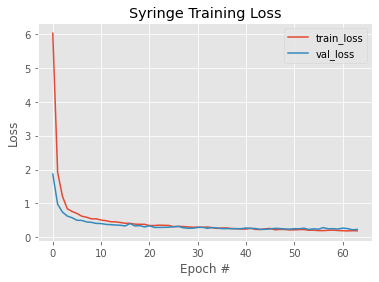

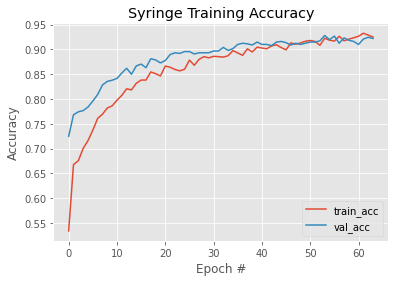

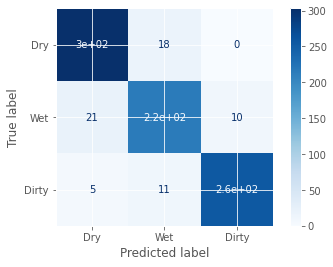

In [ ]:

def plot_loss(H, N, plotPath):
  # construct a plot that plots and saves the training history
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
  plt.title("Syringe Training Loss")
 
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")
  plt.savefig(plotPath)

def plot_accuracy(H, N, plotPath):
  # construct a plot that plots and saves the training history
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
  plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
  plt.title("Syringe Training Accuracy")

  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")
  plt.savefig(plotPath)
   
conf = {
    "base_path": "/content/drive/MyDrive/OIP_Dataset",
    "pb": "/content/drive/MyDrive/model",
    "plot_loss":"/content/drive/MyDrive/output/plot_loss2.png",
    "plot_accuracy":"/content/drive/MyDrive/output/plot_accuracy2.png"
}

# define the constants
BATCH_SIZE = 64
LEARNING_RATE = 1e-4 #0.0002
EPOCHS = 64

num_classes = 3
CLASS_NAMES = ["Dry","Wet","Dirty"]
  

# grab the path to our data created using dataset building script
basePath = conf["base_path"]

# build the paths to the data files
trainXPath = os.path.join(basePath, "trainX.cpickle")
testXPath = os.path.join(basePath, "testX.cpickle")
trainYPath = os.path.join(basePath, "trainY.cpickle")
testYPath = os.path.join(basePath, "testY.cpickle")

# load the data files 
print("[INFO] loading data files...")
trainX = pickle.loads(open(trainXPath, "rb").read())
trainY = pickle.loads(open(trainYPath, "rb").read())
testX = pickle.loads(open(testXPath, "rb").read())
testY = pickle.loads(open(testYPath, "rb").read())

print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))

# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

# initialize the training data augmentation object
# trainAug = ImageDataGenerator( horizontal_flip=True, fill_mode="nearest")
trainAug = ImageDataGenerator( rotation_range=30, width_shift_range=0.1,
                              height_shift_range=0.1, shear_range=0.2,
                              zoom_range=0.2, horizontal_flip=True, 
                              vertical_flip=True, fill_mode="nearest")
 
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
 
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

# initialize the training generator
trainGen = trainAug.flow(
  trainX,
  trainY,
  shuffle=True,
  batch_size=BATCH_SIZE,
  seed=42)
 
# initialize the testing generator
testGen = valAug.flow(
  testX,
  testY,
  shuffle=False,
  batch_size=BATCH_SIZE,
  seed=42)

# load VGG16 without the head layers
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
 
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASS_NAMES), activation="softmax")(headModel)
 
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
  layer.trainable = False

# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
 
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit_generator(trainGen, 
                        steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
                        validation_data=testGen, 
                        validation_steps=testX.shape[0] // BATCH_SIZE, 
                        class_weight=classWeight, 
                        epochs=EPOCHS)

# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = model.predict(testGen, steps=(testX.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(len(predIdxs))

#print the classification report 
print(classification_report(np.argmax(testY, axis=1), predIdxs, target_names=CLASS_NAMES))
plot_loss(H, EPOCHS, conf["plot_loss"])
plot_accuracy(H, EPOCHS, conf["plot_accuracy"])


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
y_test = np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, predIdxs)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap=plt.cm.Blues)

plt.show()

# # serialize the model as a native tf graph to disk
# print("[INFO] serializing network to a native tensorflow graph...")
# sess = K.get_session()
# frozen = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, [model.output.op.name])
# graph_io.write_graph(frozen, conf["pb"], "finalmodelvgg16.pb", as_text=False)

<Figure size 4000x4000 with 0 Axes>

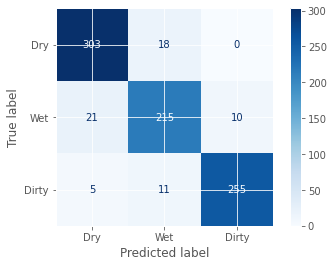

In [ ]:
# model.save('/content/drive/MyDrive/model/myModel.h5')

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


y_test = np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, predIdxs)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
figure(figsize=(50, 50), dpi=80)
disp.plot(cmap=plt.cm.Blues,values_format='')


plt.show()


In [ ]:
model.save('/content/drive/MyDrive/model/myModeltest.h5')